In [7]:
%matplotlib inline

import napari
from napari.utils import nbscreenshot
import numpy as np
import pandas as pd
import scanpy as sc

from morphometrics.data import cylinders_and_spheres
from morphometrics.explore.dimensionality_reduction import pca
from morphometrics.measure import measure_selected
from morphometrics.utils.anndata_utils import table_to_anndata

rng = np.random.default_rng(42)

In [2]:
# load the sample images
label_image, label_table, intensity_image = cylinders_and_spheres()

In [23]:
# add the sample images to the viewer
viewer = napari.view_labels(label_image, features=label_table)
viewer.add_image(intensity_image)

<Image layer 'intensity_image' at 0x7fa6d2a9e6a0>

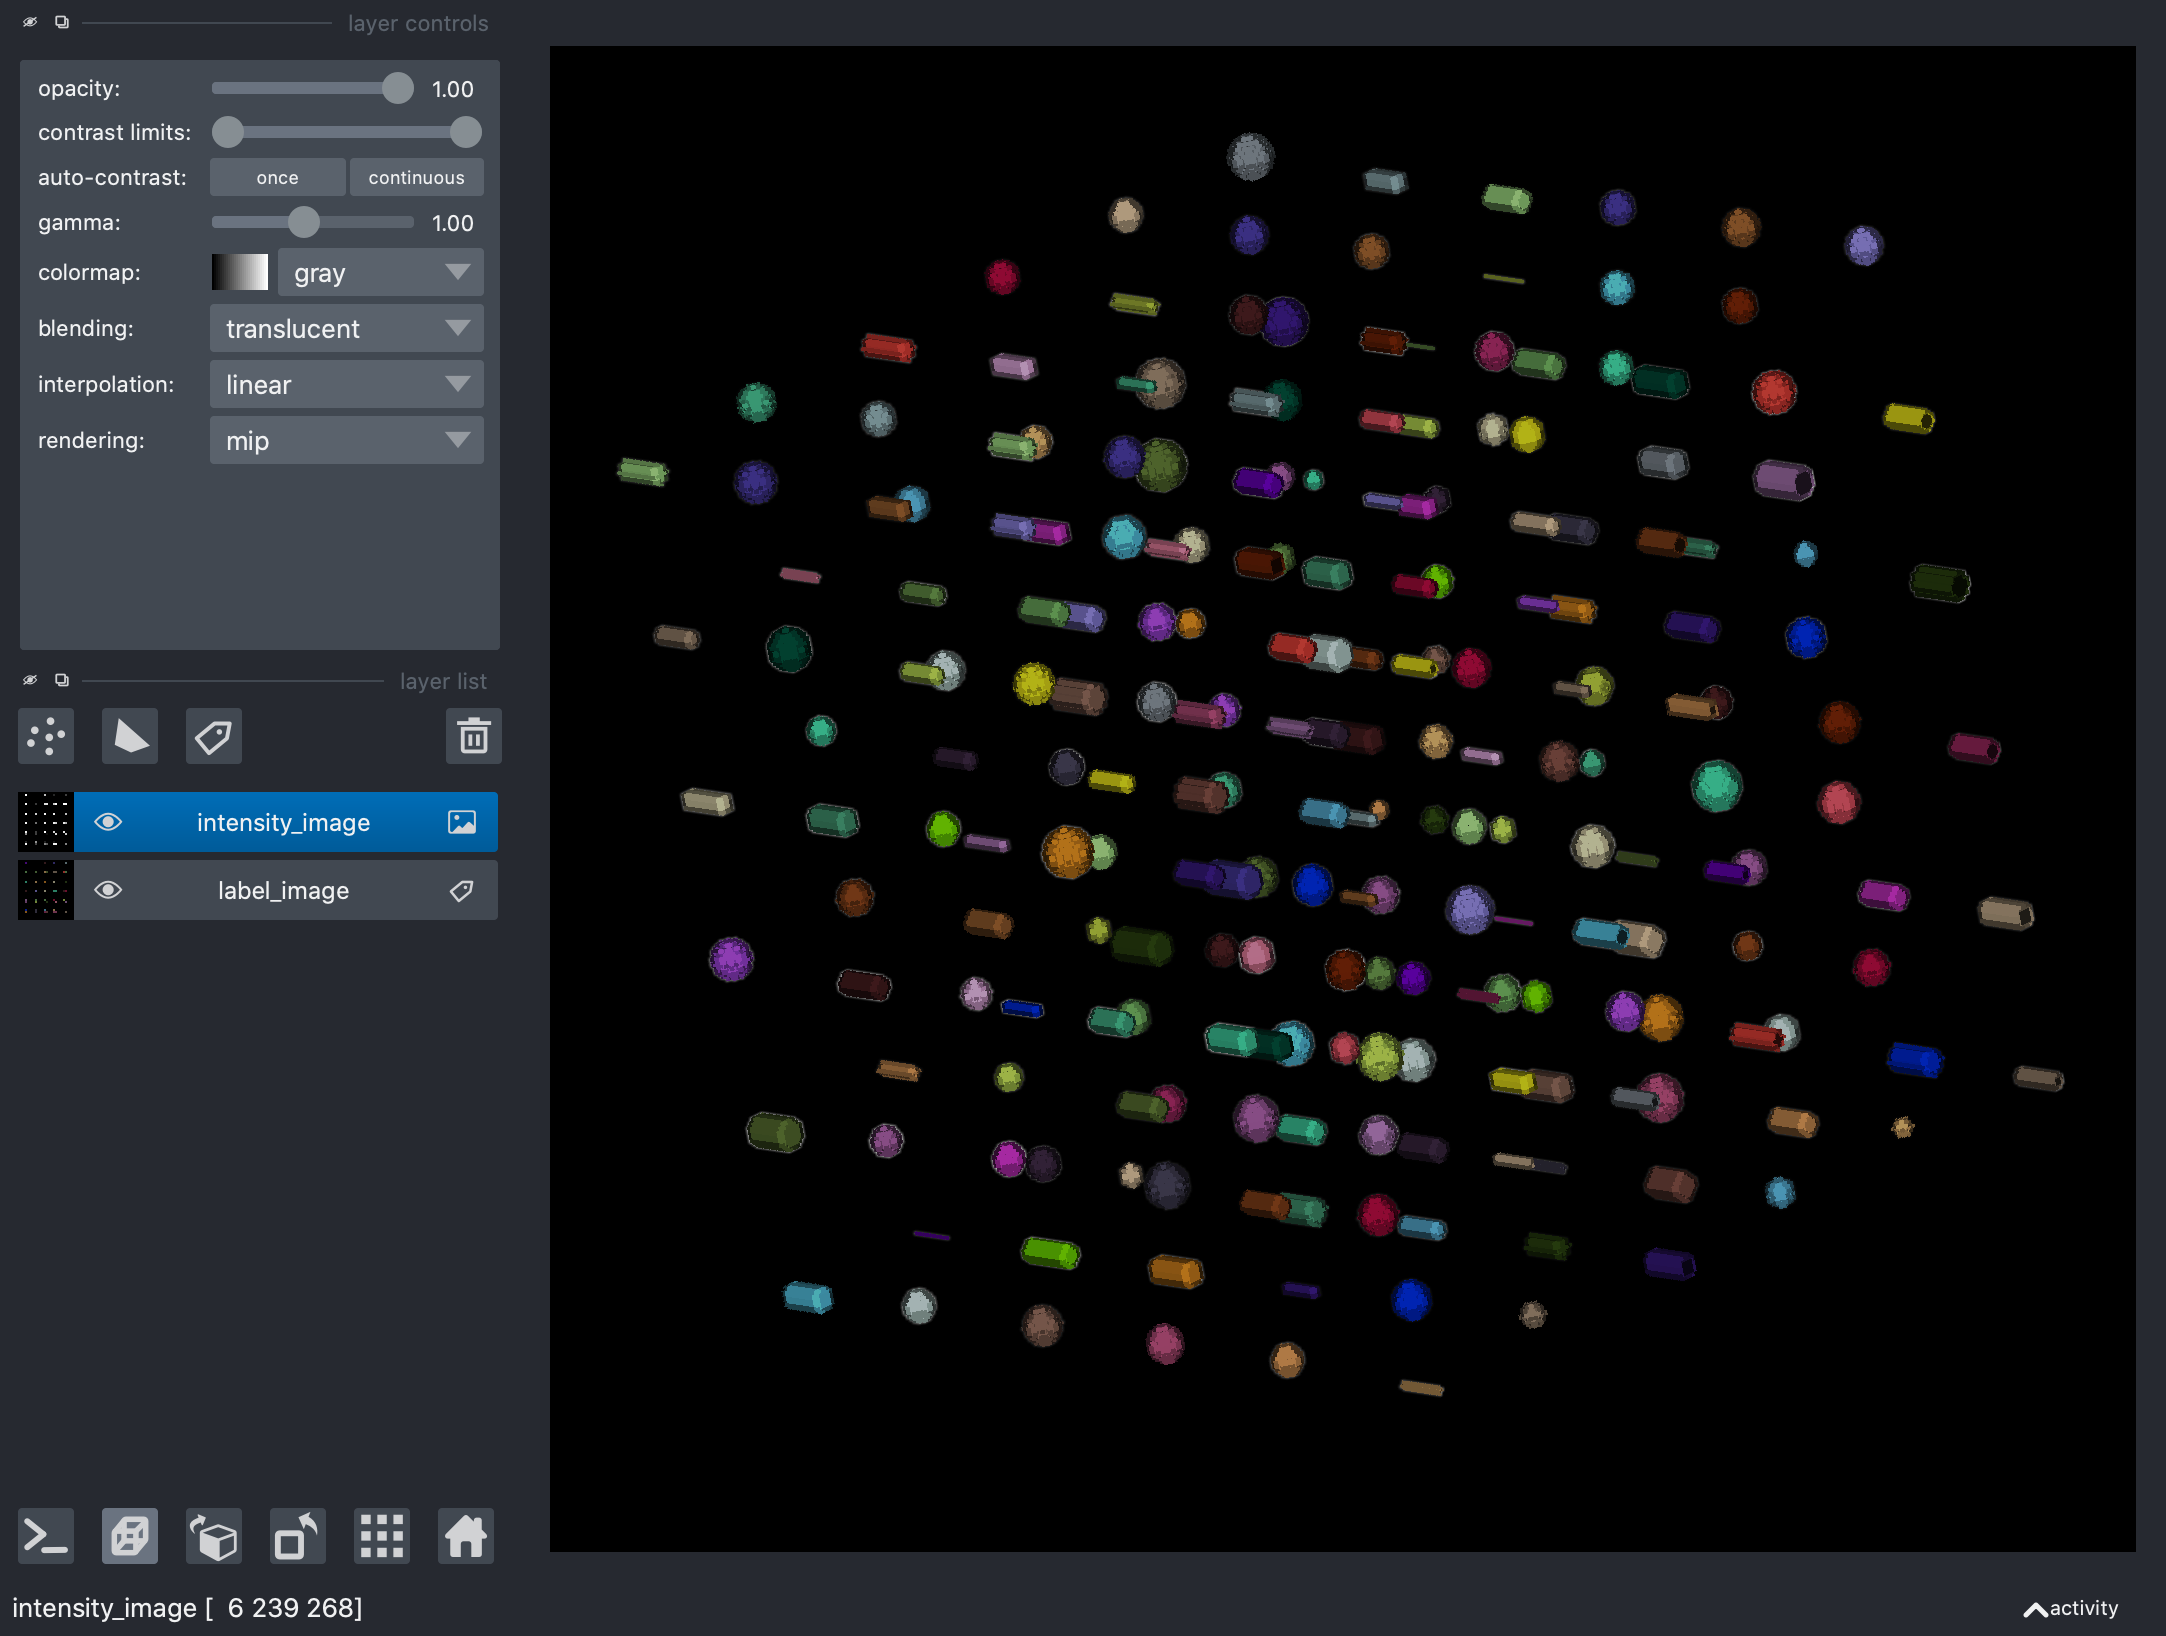

In [5]:
nbscreenshot(viewer)

In [16]:
# make the measurements

measurement_selection = [
    "surface_properties_from_labels",
    {
        "name": "regionprops",
        "choices": {
             "size": False,
            "intensity": True,
            "position": False,
            "moments": False
        },
    },
]

all_measurements = measure_selected(
    label_image=label_image,
    intensity_image=intensity_image,
    measurement_selection=measurement_selection,
)

all_measurements.head()

,surface_area,curvature_mean,curvature_stdev,curvature_0,curvature_10,curvature_20,curvature_30,curvature_40,curvature_50,curvature_60,curvature_70,curvature_80,curvature_90,curvature_100,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity
label,,,,,,,,,,,,,,,,,,
1,417.430036,-14.293573,2.459470,-27.139399,-16.381594,-15.220298,-14.850577,-14.595056,-14.427563,-14.189346,-13.920266,-12.570929,-10.589872,-9.703649,0.506809,0.506809,0.506809,2.220446e-16
2,508.499313,-12.322612,0.367468,-13.421655,-12.810478,-12.662764,-12.541363,-12.419868,-12.300170,-12.176344,-12.058551,-11.963407,-11.869599,-11.725881,0.391419,0.391419,0.391419,1.110223e-16
3,339.787071,-16.622635,2.423270,-24.169542,-19.511331,-17.551578,-17.342276,-17.139578,-17.025246,-16.728903,-15.840448,-14.435598,-13.025070,-12.091419,0.245690,0.245690,0.245690,8.326673e-17
4,335.765944,-17.230448,2.477067,-23.527325,-20.021424,-18.705770,-18.477951,-18.233245,-17.903759,-17.146973,-16.219522,-14.312775,-13.415483,-12.835149,0.138717,0.138717,0.138717,0.000000e+00
5,491.833045,-12.484151,0.162032,-12.798834,-12.668584,-12.626989,-12.588204,-12.561668,-12.502939,-12.450292,-12.401955,-12.323540,-12.228631,-12.111600,0.249357,0.249357,0.249357,2.775558e-17


In [37]:
# convert the measurement table to an AnnData object
measurement_data = table_to_anndata(
    measurement_table=all_measurements,
    obs=label_table
)

print(measurement_data)

AnnData object with n_obs × n_vars = 216 × 19
    obs: 'label', 'shape'
    var: 0


/Users/kyamauch/opt/miniconda3/envs/morphometrics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


... storing 'label' as categorical
... storing 'shape' as categorical
... storing 'label' as categorical


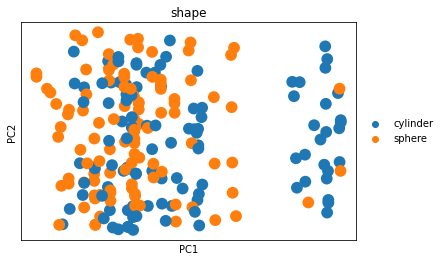

In [18]:
# Use PCA to reduce dimensionality
pca(measurement_data, normalize_data=True)
sc.pl.pca(measurement_data, color=['shape'])

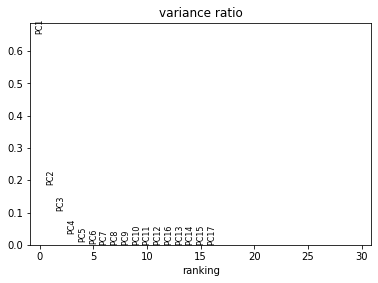

In [19]:
# plot the variation per priniciple component to determine
# how many principle components we need to build the neighbor
# graph
sc.pl.pca_variance_ratio(measurement_data)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
... storing 'label' as categorical
... storing 'label' as categorical


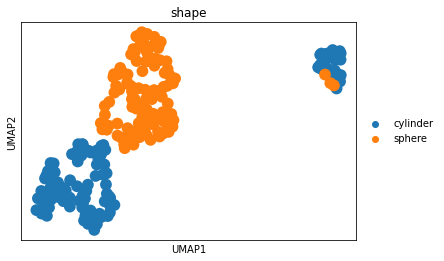

In [20]:
# Build the neighbor graph and calculate UMAP

sc.pp.neighbors(measurement_data, n_pcs=6)
sc.tl.leiden(measurement_data)
sc.tl.umap(measurement_data)
sc.pl.umap(measurement_data, color='shape')

In [24]:
# add the UMAP coordinates to the napari labels layer features
labels_features = viewer.layers['label_image'].features
labels_features['umap_0'] = measurement_data.obsm['X_umap'][:, 0]
labels_features['umap_1'] = measurement_data.obsm['X_umap'][:, 1]

viewer.layers['label_image'].features = labels_features

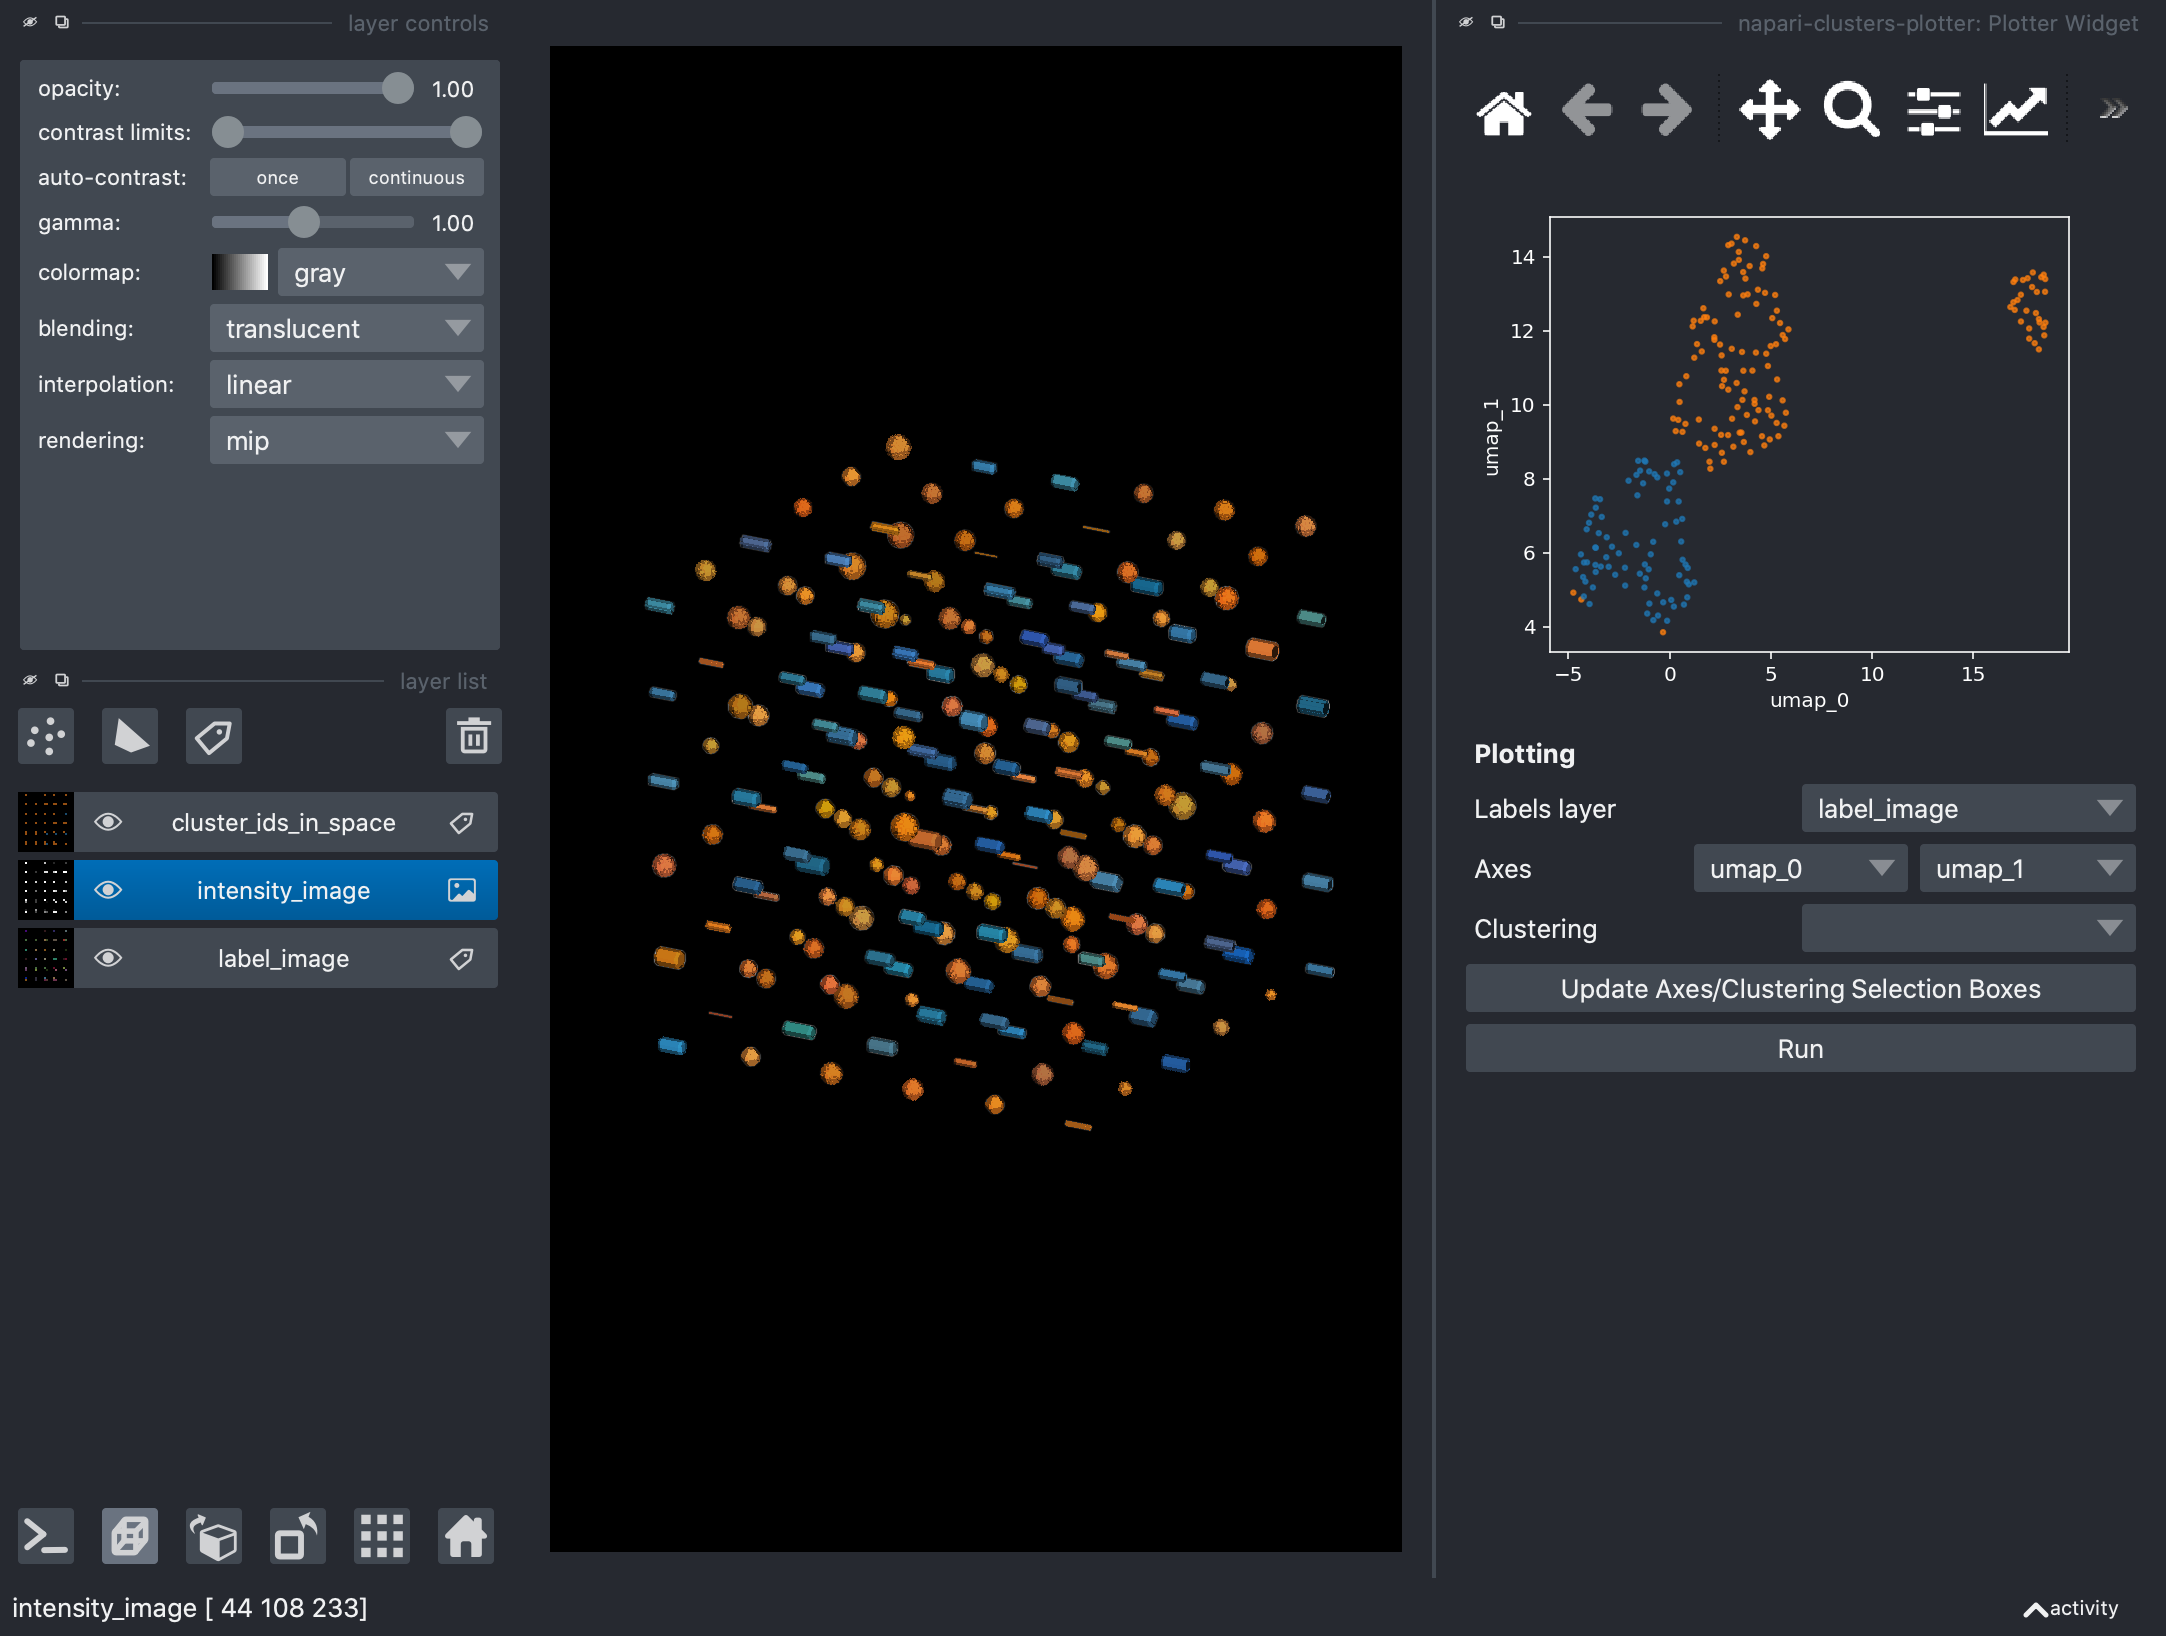

In [27]:
# You can use the "Plotter widget" from the napari-clusters-plotter
# plugin to select objects from the UMAP
nbscreenshot(viewer)

In [22]:
# encode the shape as 0=cylinder and sphere=1 so we can train
# a random forest classifier to predict shape from the
# measured features
obs = measurement_data.obs
obs['shape_label'] = obs['shape'].map({'cylinder': 0, 'sphere': 1})
y = obs['shape_label'].to_numpy()

In [28]:
from sklearn.model_selection import train_test_split

# spit the data into test and train sets
X = measurement_data.X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [29]:
from sklearn.ensemble import RandomForestClassifier

# train the random forest classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
from sklearn import metrics

# test the classifier performance on the test data set
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [41]:
# display predictions in napari viewer

y_pred_all = clf.predict(X)

prediction_image = np.zeros_like(label_image)

for shape_prediction, label_index in zip(y_pred_all, obs['label']):
    prediction_image[label_image == label_index] = shape_prediction + 1

viewer.add_labels(prediction_image, color={1: [0, 1, 0, 1], 2: [1, 0, 1, 1]})

<Labels layer 'prediction_image' at 0x7fa5dac1ae20>

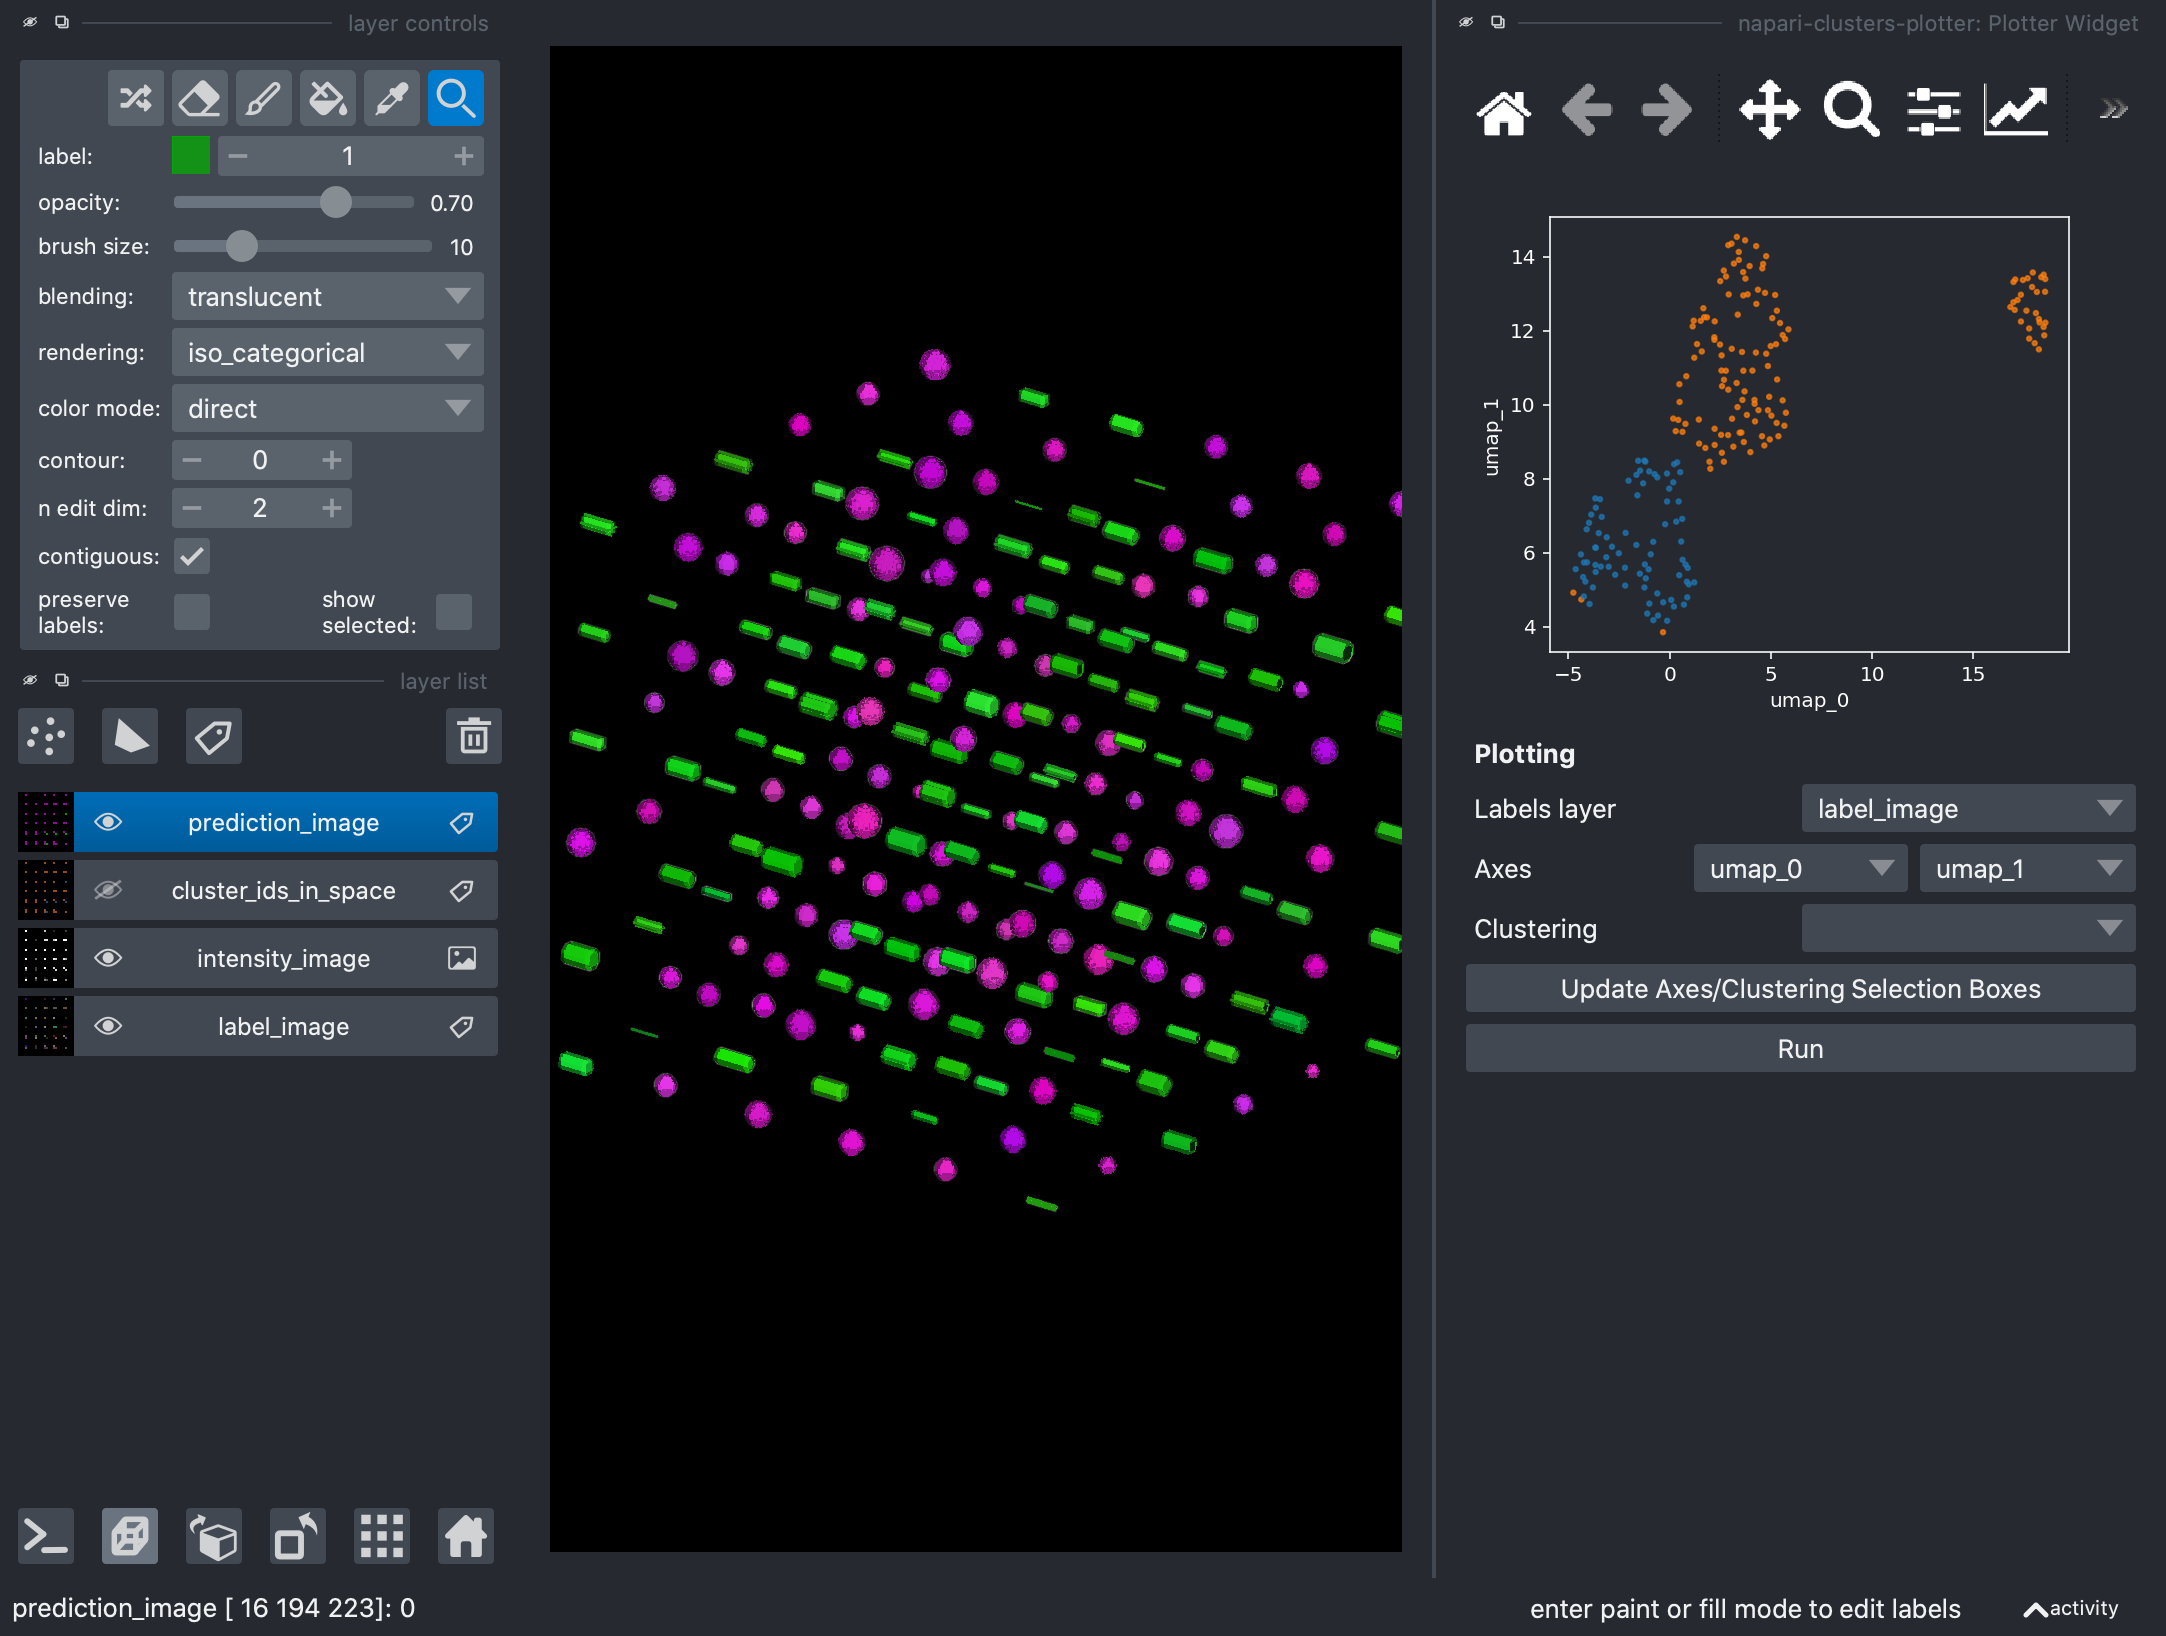

In [42]:
# predicted spheres shown in magenta and cylinders in green!
nbscreenshot(viewer)